In [1]:
%load_ext autoreload
%autoreload 2
from train import *

### mixed training

In [3]:
task_list = ['PRO_D', 'PRO_M', 'ANTI_D', 'ANTI_M']
z_list = ['F/D', 'S', 'R_P', 'R_M_P', 'R_A', 'R_M_A']
dim_z = len(z_list)
model_kwargs = {'dim_z': dim_z, 'rank': dim_z, 'dim_hid': 50, 'alpha': 0.5, 'gating_type': 'nl'} 
if isinstance(model_kwargs['gating_type'], int):
    model_kwargs['rank'] *= model_kwargs['gating_type']

save_dir = './saved_models/cxtrnn_gating' + str(model_kwargs['gating_type'])
os.makedirs(save_dir, exist_ok=True)
if os.path.isfile(save_dir + '/model.pth'):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = CXTRNN(**model_kwargs).to(device)
    save_dict = torch.load(save_dir + '/model.pth', map_location=torch.device(device))
    model.load_state_dict(save_dict)
    tr_loss_arr = np.load(save_dir + '/tr_loss.npy')
    ts_loss_arr = np.load(save_dir + '/ts_loss.npy')
else:
    model, tr_loss_arr, ts_loss_arr = train_rnn(model_kwargs, epochs=20, seed=0, 
                                                n_trials=25600, batch_size=256, save_dir=save_dir)

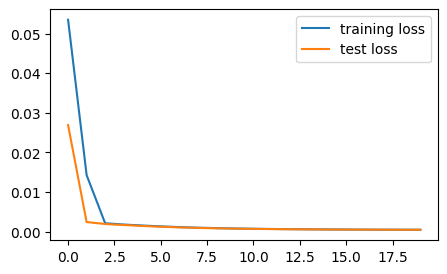

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(tr_loss_arr, label='training loss')
ax.plot(ts_loss_arr, label='test loss')
ax.legend()

### sequential training

In [12]:
task_list = ['PRO_D', 'PRO_M', 'ANTI_D', 'ANTI_M']
z_list = ['F/D', 'S', 'R_P', 'R_M_P', 'R_A', 'R_M_A']
dim_z = len(z_list)
model_kwargs = {'dim_z': dim_z, 'rank': dim_z, 'dim_hid': 50, 'alpha': 0.5, 'gating_type': 3} 
if isinstance(model_kwargs['gating_type'], int):
    model_kwargs['rank'] *= model_kwargs['gating_type']

save_dir = './saved_models/cxtrnn_seq_gating' + str(model_kwargs['gating_type'])
os.makedirs(save_dir, exist_ok=True)
if os.path.isfile(save_dir + '/model.pth'):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = CXTRNN(**model_kwargs).to(device)
    save_dict = torch.load(save_dir + '/model.pth', map_location=torch.device(device))
    model.load_state_dict(save_dict)
    tr_loss_arr = np.load(save_dir + '/tr_loss.npy')
    ts_loss_arr = np.load(save_dir + '/ts_loss.npy')
else:
    model, tr_loss_arr, ts_loss_arr = train_rnn_sequential(model_kwargs, seed=0, lr=0.01,
                                                           batch_size=256, num_iter=500, n_trials_ts=200,
                                                           task_list=task_list, z_list=z_list,
                                                           verbose=True, save_dir=save_dir)

Text(0, 0.5, 'test loss')

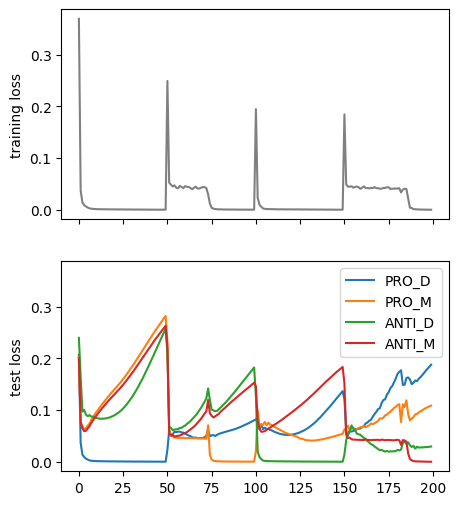

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True, sharey=True)
axes[0].plot(tr_loss_arr, color='gray')
for itask in range(4):
    axes[1].plot(ts_loss_arr[itask], color=f'C{itask}', label=task_list[itask])
axes[1].legend()
axes[0].set_ylabel('training loss')
axes[1].set_ylabel('test loss')

### visualize gating for each task epoch

[0.29347298 0.52736115 0.2817344  0.36125988 0.5177684  0.41869655]
[0.2978565  0.45104817 0.2674186  0.32830718 0.4277692  0.38320172]
[0.56286854 0.35652533 0.8295572  0.6022658  0.31566215 0.39519325]
[0.5966628  0.3801497  0.8577038  0.7380979  0.41210636 0.45949465]
[0.6589919 0.5987204 0.7803947 0.276566  0.2788103 0.6354933]
[0.6953631  0.6505535  0.788884   0.25769776 0.32657862 0.7906793 ]


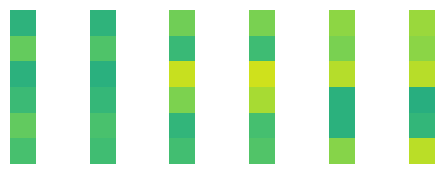

In [5]:
fig, axes = plt.subplots(1, dim_z, figsize=(dim_z, 2))
for iz in range(dim_z):
    z_t = torch.zeros(dim_z, device=device)
    z_t[iz] = 1
    gating = model.gating(z_t.unsqueeze(0))
    gating = gating.detach().cpu().numpy()[0]
    print(gating)
    axes[iz].imshow(gating[:, None], vmin=-1, vmax=1)
    axes[iz].axis('off')

### out of distribution generalization

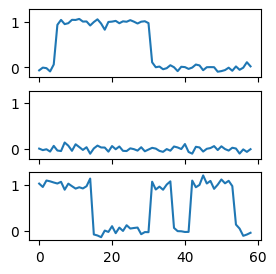

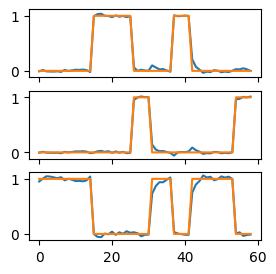

In [6]:
epoch_str = 'F/D->S->R_P->R_A->F/D->R_M_P->F/D->R_M_A' #
x = 0#np.random.choice([0, 1])
sig_s = 0.05 
sig_y = 0 
p_stay = 0.9
min_Te = 5
sy, boundaries = compose_trial(epoch_str, {'theta_task': x}, sig_s, sig_y, p_stay, min_Te)
all_Te = np.diff([0] + list(boundaries))
z = [[z_list.index(cur)] * Te for cur, Te in zip(epoch_str.split('->'), all_Te)]
z = np.array([j for i in z for j in i])[:, None]
syz = np.concatenate([sy['s'], sy['y'], z], axis=-1)
syz = torch.tensor(syz[:, None, :], dtype=torch.float32)
syz = syz.to(device)
s, y, z = syz[..., :3], syz[..., 3:6], syz[..., -1]
z = F.one_hot(z.to(torch.int64), num_classes=dim_z).float()
with torch.no_grad():
    out = model(s, z)
fig, axes = plt.subplots(3, 1, figsize=(3, 3), sharey=True, sharex=True)
for iax in range(3):
    axes[iax].plot(s[:, :, iax].cpu().numpy())
fig, axes = plt.subplots(3, 1, figsize=(3, 3), sharey=True, sharex=True)
for iax in range(3):
    axes[iax].plot(out[:, :, iax].cpu().numpy())
    axes[iax].plot(y[:, :, iax].cpu().numpy())

### fixed points


Searching for fixed points from 5 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		284 iters
		q = 6.76e-13 +/- 4.90e-14
		dq = 1.54e-13 +/- 1.36e-13
		learning rate = 9.02e-01
		avg iter time = 1.52e-03 sec
	Identified 2 unique fixed points.
		initial_states: 0 outliers detected (of 5).
		fixed points: 0 outliers detected (of 2).
	Computing recurrent Jacobian at 2 unique fixed points.
	Computing input Jacobian at 2 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 5 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		277 iters
		q = 2.36e-01 +/- 1.92e-01
		dq = 1.85e-14 +/- 2.56e-14
		learning rate

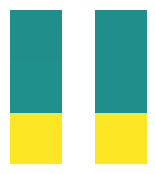

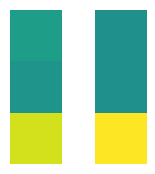

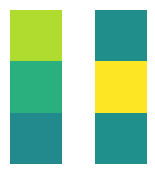

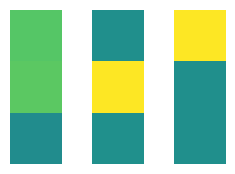

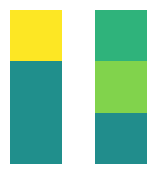

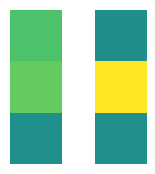

In [41]:
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder

class FUNC(nn.Module):
    def __init__(self, iz):
        super(FUNC, self).__init__()
        z_t = torch.zeros(dim_z, device=device)
        z_t[iz] = 1
        self.z_t = nn.Parameter(z_t, requires_grad=False)
        self.batch_first = True
    
    def forward(self, s_t, state):
        s_t = s_t.squeeze(1)
        state = state.squeeze(0)
        tmp = torch.einsum('r,hr,kr,bk->bh', model.gating(self.z_t.unsqueeze(0)).squeeze(0), model.U, model.V, torch.tanh(state))
        x = (1 - model.alpha) * state + model.alpha * (tmp + model.input_layer(s_t))
        y = model.output_layer(x)
        return y, x


fpf_hps = {
    'max_iters': 10000,
    'lr_init': 1.,
    'outlier_distance_scale': 10.0,
    'verbose': True, 
    'super_verbose': False}

z_list = ['F/D', 'S', 'R_P', 'R_M_P', 'R_A', 'R_M_A']
dim_z = len(z_list)
rs = np.random.RandomState(seed=0)
for iz in range(6):
    func = FUNC(iz).to(device)
    fpf = FixedPointFinder(func, **fpf_hps)
    initial_states = rs.randn(5, 50)
    inputs = [np.array([[0, 0, 1]]), 
              np.array([[0, 1, 1]]),
              np.array([[0, 1, 0]]),
              np.array([[0, 0, 0]]),
              np.array([[0, 1, 0]]),
              np.array([[0, 0, 0]])][iz]
    fps = fpf.find_fixed_points(initial_states, inputs)
    with torch.no_grad():
        ystar = model.output_layer(torch.tensor(fps[0].xstar, device=device)).detach().cpu().numpy()
        fig, axes = plt.subplots(1, len(ystar), figsize=(len(ystar), 2))
        for i in range(len(ystar)):
            axes[i].imshow(ystar[i][:, None], vmin=-1, vmax=1)
            axes[i].axis('off')